In [1]:
## PCA
## Library: CD8-HP
## This file contains the basic function of PCA.
## Author: Xiang Li

###Sample
#### Imput Package
import pandas as pd
import numpy as np
import os

In [2]:
import matplotlib
matplotlib.use('AGG')
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("white") 

# display plots in this notebook
%matplotlib inline

In [3]:
#Functions to read cuffdiff outputs
def generate_genes_FPKM_df(fname, sample_name_dict):
    df = pd.read_csv(fname, sep='\t', header=0)
    
    FPKM_df = None
    for condition in set(df.condition):
        for replicate in set(df.replicate):
            temp_df = df[(df.condition == condition) & (df.replicate == replicate) & (df.FPKM >=1)].loc[:,['tracking_id', 'FPKM']]
            temp_df.rename(columns={'tracking_id': 'gene_id', 'FPKM': sample_name_dict[(condition, replicate)]}, inplace=True)
            if FPKM_df is None:
                FPKM_df = temp_df
            else:
                #FPKM_df = FPKM_df.merge(temp_df, on='gene_id')
                FPKM_df = FPKM_df.merge(temp_df, how='outer')
    FPKM_df = FPKM_df.dropna(axis=1, how='all')
    FPKM_df = FPKM_df.dropna(axis=0, how='any')
    return FPKM_df

In [15]:
os.getcwd()

'/mnt/d/bioproject/Data/Haihui/Tcf1/HP'

In [4]:
#FPKM
PATH_FOLDER=os.getcwd()
################################################################################
WT_PATH=PATH_FOLDER+'/WT/'
WT_sample_name_dict = {('WT_CD8_0h', 0): 'WT1_CD8_0h', ('WT_CD8_0h', 1): 'WT2_CD8_0h', \
                       ('WT_CD8_72h', 0): 'WT1_CD8_72h', ('WT_CD8_72h', 1): 'WT2_CD8_72h' }
WT_FPKM_df = generate_genes_FPKM_df(WT_PATH+'genes.read_group_tracking', WT_sample_name_dict)
################################################################################
################################################################################
DKO_PATH=PATH_FOLDER+'/DKO/'
DKO_sample_name_dict = {('DKO_CD8_0h', 0): 'DKO1_CD8_0h', ('DKO_CD8_0h', 1): 'DKO2_CD8_0h', \
                    ('DKO_CD8_72h', 0): 'DKO1_CD8_72h', ('DKO_CD8_72h', 1): 'DKO2_CD8_72h'}
DKO_FPKM_df = generate_genes_FPKM_df( DKO_PATH+'genes.read_group_tracking', DKO_sample_name_dict)
################################################################################
################################################################################
Ctrl_PATH=PATH_FOLDER+'/Ctrl-n_Ctrl-s/'
Ctrl_sample_name_dict = {('Ctrl-n', 0): 'Ctrl-3n', ('Ctrl-n', 1): 'Ctrl-4n', \
                       ('Ctrl-s', 0): 'Ctrl-3s', ('Ctrl-s', 1): 'Ctrl-3s_fake' }
Ctrl_FPKM_df = generate_genes_FPKM_df(Ctrl_PATH+'genes.read_group_tracking', Ctrl_sample_name_dict)
################################################################################
################################################################################
dKO_PATH= PATH_FOLDER+'/dKO-n_dKO-s/'
dKO_sample_name_dict = {('dKO-n', 0): 'dKO-3n', ('dKO-n', 1): 'dKO-4n', \
                    ('dKO-s', 0): 'dKO-3s' , ('dKO-s', 1): 'dKO-3s_fake'}
dKO_FPKM_df = generate_genes_FPKM_df(dKO_PATH+'genes.read_group_tracking', dKO_sample_name_dict)
################################################################################
################################################################################
#### FPKM Merge and heatmap
FPKM_df = WT_FPKM_df.merge(DKO_FPKM_df, on='gene_id')
FPKM_df = FPKM_df.merge(Ctrl_FPKM_df, on='gene_id')
FPKM_df = FPKM_df.merge(dKO_FPKM_df, on='gene_id')

FPKM_df = FPKM_df.loc[:,['gene_id','WT1_CD8_0h','WT2_CD8_0h','Ctrl-3n', 'Ctrl-4n', 'DKO1_CD8_0h', 'DKO2_CD8_0h', 'dKO-3n', 'dKO-4n', 'WT1_CD8_72h','WT2_CD8_72h','Ctrl-3s', 'DKO1_CD8_72h', 'DKO2_CD8_72h', 'dKO-3s']]


######## Choose data matched to gene list kept
diff_exps_gene_list = pd.read_csv( PATH_FOLDER +'/Differential_Expression_genelists.csv', header=None, names={'gene_id'}  )

diff_exps_gene_list_df= FPKM_df.merge(diff_exps_gene_list, on='gene_id')

diff_exps_gene_list_df = diff_exps_gene_list_df.set_index('gene_id')


In [19]:
matplotlib.__version__
colors

['C0',
 'C1',
 'C2',
 'C3',
 'C4',
 'C5',
 'C6',
 'C7',
 'C8',
 'C9',
 'C10',
 'C11',
 'C12',
 'C13']

In [17]:
# PCA
df_2 = diff_exps_gene_list_df #.reset_index()

#### Remove unicode of list in python 
df2_gene_id = [x.encode('ascii', 'ignore') for x in df_2.index]


from sklearn.decomposition import PCA
from sklearn import datasets
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.preprocessing import StandardScaler

#### In here we set targets as the name of columns, which means our purpose is to compare \
#### the relationship between different columns.
targets= [x.encode('ascii', 'ignore') for x in df_2.columns]

colors=[]
for i in range(len(targets)):
    colors.append( "C"+ str(i))
    #print(colors[i])

################################################################################

df_2_T = df_2.transpose()

# Separating out the features
x = df_2_T.loc[ :, df2_gene_id ].values


# Separating out the target
y = df_2_T.loc[targets,:].values


# Standardizing the featuresbio
x = StandardScaler().fit_transform(x)

pca = PCA(n_components=2)
principalComponents = pca.fit_transform(x)
principalDf = pd.DataFrame(data = principalComponents
             , columns = ['principal component 1', 'principal component 2'])


########### THIS is fucking killing me. reindex df with df2, just using following command.
principalDf.index = df_2_T.index

#finalDf = pd.concat( [principalDf, df_2_T.loc['target']], axis = 1)
principalDf

,principal component 1,principal component 2
WT1_CD8_0h,-21.538335,8.155823
WT2_CD8_0h,-31.200217,-1.784229
Ctrl-3n,-15.186366,62.164145
Ctrl-4n,-15.763109,62.817795
DKO1_CD8_0h,-42.512866,-34.987964
DKO2_CD8_0h,-44.006657,-26.379913
dKO-3n,-14.833832,21.368600
dKO-4n,-49.190503,-32.514153
WT1_CD8_72h,57.610420,-6.762036
WT2_CD8_72h,44.885127,-0.482170


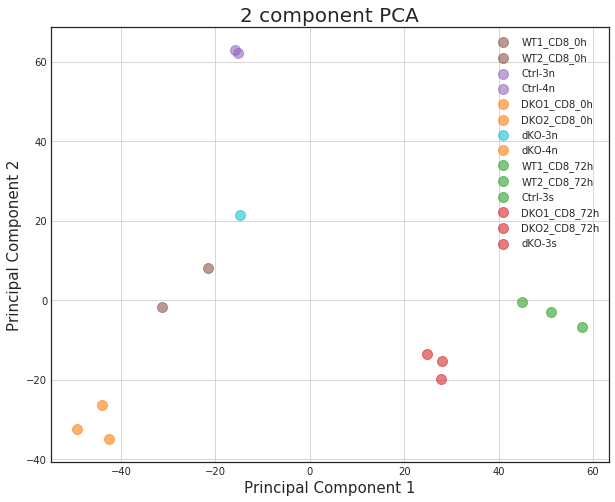

In [27]:
### PLOT

fig = plt.figure(figsize = (10,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 component PCA', fontsize = 20)

colors = ['C5','C5','C4','C4', 'C1', 'C1','C9','C1', 'C2','C2','C2', 'C3','C3','C3']

for target, color in zip( targets,colors):
    indicesToKeep = principalDf.index == target
    ax.scatter(principalDf.loc[indicesToKeep, 'principal component 1']
               , principalDf.loc[indicesToKeep, 'principal component 2']
               , s = 100, c=color, alpha=0.6)
ax.legend(targets)
#ax.set_xlim(-2,8)
ax.grid()
Parameters_Detail='CD8_HP'
fig.savefig('PCA'+Parameters_Detail+'.png')
